<a href="https://colab.research.google.com/github/MerkulovDaniil/intro_opt/blob/master/notebooks/intro_opt_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Examples

## Wolfe’s example

In [1]:
import jax.numpy as jnp
from jax import grad

def f(x):
    x1, x2 = x
    ans = (x1 > jnp.abs(x2))*5*jnp.sqrt(9*x1**2 + 16*x2**2) + (x1 <= jnp.abs(x2))*(9*x1 + 16*jnp.abs(x2))
    if ans.any() > 50:
        print(f"x1 {x1}, x2 {x2}, f {ans}")
    return ans

df = grad(f)

In [2]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from matplotlib import pyplot as plt

def plot_3d_function(x1, x2, f, title, minima = None, iterations = None):
    '''
    '''
    low_lim_1 = x1.min()
    low_lim_2 = x2.min()
    up_lim_1 = x1.max()
    up_lim_2 = x2.max()
    X1, X2 = np.meshgrid(x1, x2) # grid of point
    Z = f((X1, X2)) # evaluation of the function on the grid

    # set up a figure twice as wide as it is tall
    fig = plt.figure(figsize=(16,7))
    fig.suptitle(title)
    #===============
    # First subplot
    #===============
    # set up the axes for the first plot
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    # plot a 3D surface like in the example mplot3d/surface3d_demo
    surf = ax.plot_surface(X1, X2, Z, rstride=1, cstride=1,
    cmap=cm.RdBu,linewidth=0, antialiased=False)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    if minima is not None:
        minima_ = np.array(minima).reshape(-1, 1)
        ax.plot(*minima_, f(minima_), 'r*', markersize=10)


    #===============
    # Second subplot
    #===============
    # set up the axes for the second plot
    ax = fig.add_subplot(1, 2, 2)
    # plot a 3D wireframe like in the example mplot3d/wire3d_demo
    im = ax.imshow(Z,cmap=plt.cm.RdBu, origin = "lower", extent=[low_lim_1, up_lim_1, low_lim_2, up_lim_2])
    cset = ax.contour(X1, X2, Z,linewidths=2,cmap=plt.cm.Set2)
    ax.clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
    fig.colorbar(im)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')

    if minima is not None:
        minima_ = np.array(minima).reshape(-1, 1)
        ax.plot(*minima_, 'r*', markersize=10)

    if iterations is not None:
        for point in iterations:
            ax.plot(*point, 'go', markersize=3)
        iterations = np.array(iterations).T
        ax.quiver(iterations[0,:-1], iterations[1,:-1], iterations[0,1:]-iterations[0,:-1], iterations[1,1:]-iterations[1,:-1], scale_units='xy', angles='xy', scale=1, color='blue')
    plt.savefig('plot_3d.svg')
    plt.show()


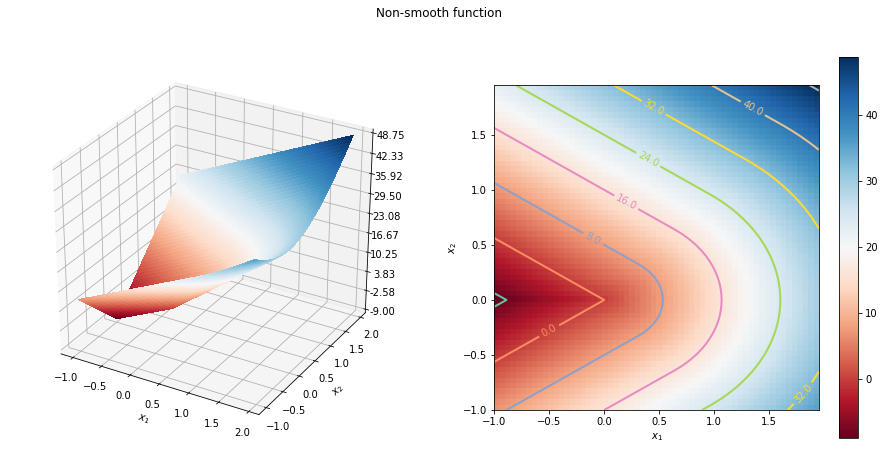

In [3]:
up_lim = 2
low_lim = -1
x1 = np.arange(low_lim, up_lim, 0.05)
x2 = np.arange(low_lim, up_lim, 0.05)
title = f'Non-smooth function'
plot_3d_function(x1, x2, f, title)

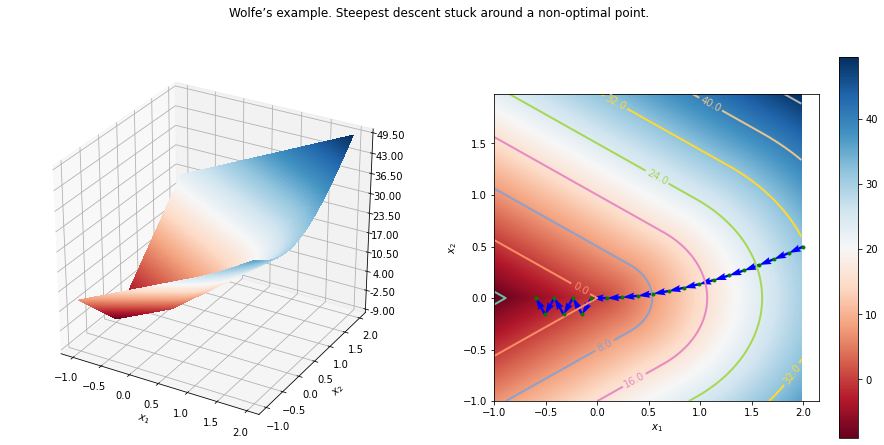

In [13]:
from scipy.optimize import minimize_scalar
def steepest_descent(x_0, f, df, df_eps = 1e-2, max_iter = 1000):
    iterations = []
    x = np.array(x_0)
    iterations.append(x)
    while np.linalg.norm(df(x)) > df_eps and len(iterations) <= max_iter:
        # res = minimize_scalar(lambda alpha: f(x - alpha * df(x)))
        alpha_opt = 0.01
        # alp
        x = x - alpha_opt * df(x)
        iterations.append(x)
    #print('Finished with', len(iterations), 'iterations')
    return iterations
x_0 = [2.,0.5]
k = 100
iterations = steepest_descent(x_0, f, df, max_iter=20)
title = f'Wolfe’s example. Steepest descent stuck around a non-optimal point.'
up_lim = 2
low_lim = -1
x1 = np.arange(low_lim, up_lim, 0.02)
x2 = np.arange(low_lim, up_lim, 0.02)
plot_3d_function(x1, x2, f, title, iterations = iterations)


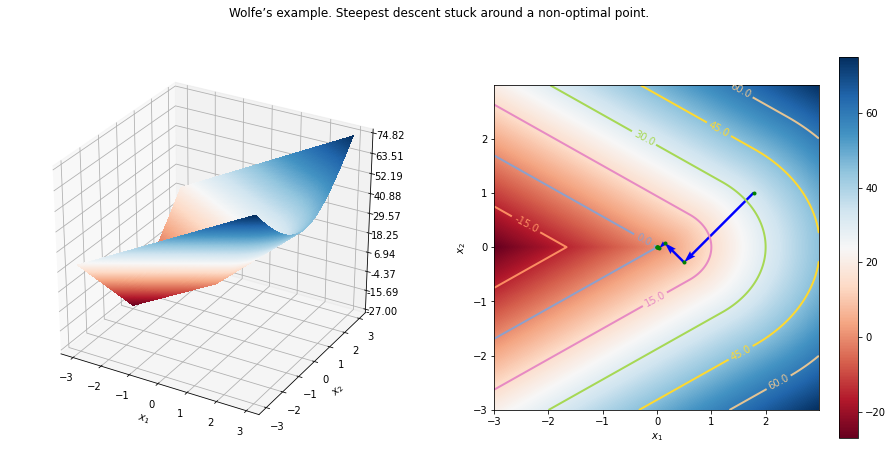

In [5]:
title = f'Wolfe’s example. Steepest descent stuck around a non-optimal point.'
up_lim = 3
low_lim = -3
x1 = np.arange(low_lim, up_lim, 0.02)
x2 = np.arange(low_lim, up_lim, 0.02)
plot_3d_function(x1, x2, f, title, iterations = iterations)

In [9]:
df(x_0)

[DeviceArray(14.230249, dtype=float32), DeviceArray(6.3245554, dtype=float32)]

## Playing with gradient methods

Materials from [EE227C course page](https://ee227c.github.io/). [Download ipynb file with this part](https://ee227c.github.io/code/lecture4.ipynb)

In [14]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

np.random.seed(228)

kwargs = {'linewidth' : 3.5}
font = {'weight' : 'normal', 'size'   : 24}
matplotlib.rc('font', **font)

def error_plot(ys, yscale='log'):
    plt.figure(figsize=(8, 8))
    plt.xlabel('Step')
    plt.ylabel('Error')
    plt.yscale(yscale)
    plt.plot(range(len(ys)), ys, **kwargs)

### Projected gradient descent

We start with a basic implementation of projected gradient descent.

In [15]:
def gradient_descent(init, steps, grad, proj=lambda x: x):
    """Projected gradient descent.
    
    Inputs:
        initial: starting point
        steps: list of scalar step sizes
        grad: function mapping points to gradients
        proj (optional): function mapping points to points
        
    Returns:
        List of all points computed by projected gradient descent.
    """
    xs = [init]
    for step in steps:
        xs.append(proj(xs[-1] - step * grad(xs[-1])))
    return xs

Note that this implementation keeps around all points computed along the way. This is clearly not what you would do on large instances. We do this for illustrative purposes to be able to easily inspect the computed sequence of points.

### Warm-up: Optimizing a quadratic

As a toy example, let's optimize $$f(x)=\frac12\|x\|^2,$$ which has the gradient map $\nabla f(x)=x.$

In [17]:
def quadratic(x):
    return 0.5*x.dot(x)

# def quadratic_gradient(x):
#     return x

quadratic_gradient = grad(quadratic)

Note the function is $1$-smooth and $1$-strongly convex. Our theorems would then suggest that we use a constant step size of $1.$ If you think about it, for this step size the algorithm will actually find the optimal solution in just one step.

In [19]:
x0 = np.random.normal(0, 1, (1000))
_, x1 = gradient_descent(x0, [1.0], quadratic_gradient)

Indeed, it does.

In [20]:
x1.all() == 0

DeviceArray(True, dtype=bool)

Let's say we don't have the right learning rate. 

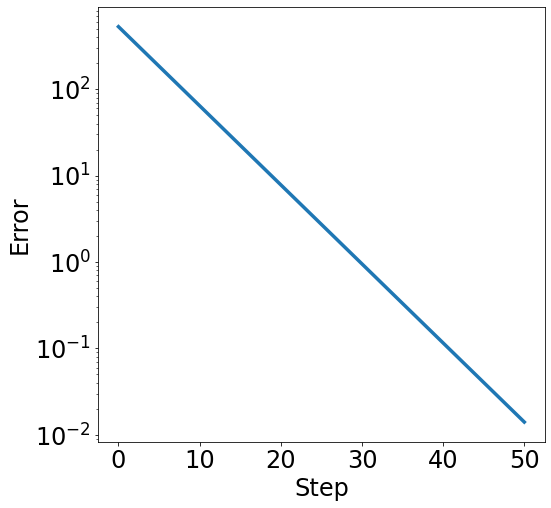

In [21]:
xs = gradient_descent(x0, [0.1]*50, quadratic_gradient)
error_plot([quadratic(x) for x in xs])

#### Constrained optimization

Let's say we want to optimize the function inside some affine subspace. Recall that affine subspaces are convex sets. Below we pick a random low dimensional affine subspace $b+U$ and define the corresponding linear projection operator.

In [23]:
# U is an orthonormal basis of a random 100-dimensional subspace.
U = np.linalg.qr(np.random.normal(0, 1, (1000, 100)))[0]
b = np.random.normal(0, 1, 1000)

def proj(x):
    """Projection of x onto an affine subspace"""
    return b + U.dot(U.T).dot(x-b)

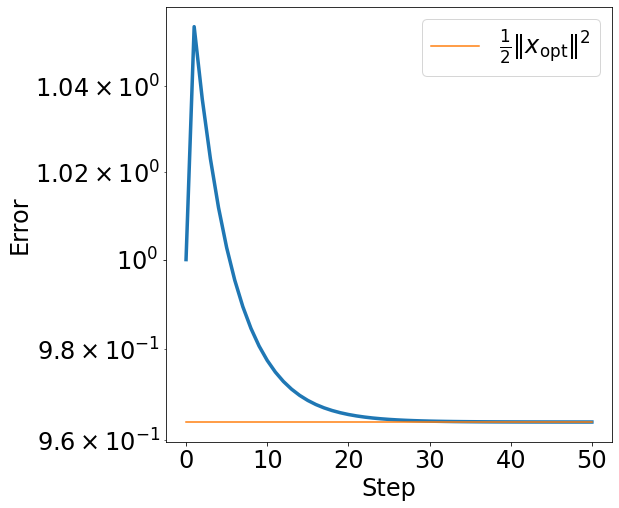

In [28]:
x0 = np.random.normal(0, 1, (1000))
xs = gradient_descent(x0, [0.1]*50, quadratic_gradient, proj)
# the optimal solution is the projection of the origin
x_opt = proj(0)
error_plot([quadratic(x)/quadratic(xs[0]) for x in xs])
plt.plot(range(len(xs)), [quadratic(x_opt)/quadratic(xs[0])]*len(xs),
        label='$\\frac{1}{2}|\!|x_{\mathrm{opt}}|\!|^2$')
plt.legend()

The orangle line shows the optimal error, which the algorithm reaches quickly. The iterates also converge to the optimal solution in domain as the following plot shows.

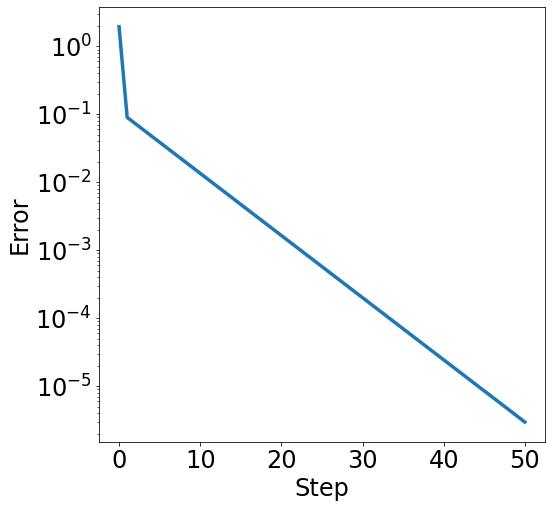

In [29]:
error_plot([np.linalg.norm(x_opt-x)**2/np.linalg.norm(xs[0])**2 for x in xs])

### Least Squares 

One of the most fundamental data analysis tools is *linear least squares*. Given an $m\times n$ matrix $A$ and a vector $b$ our goal is to find a vector $x\in\mathbb{R}^n$ that minimizes the following objective: 

<p>
$$f(x) = \frac 1{2m}\sum_{i=1}^m (a_i^\top x - b_j)^2 
=\frac1{2m}\|Ax-b\|^2$$
</p>

We can verify that $\nabla f(x) = A^\top(Ax-b)$ and
$\nabla^2 f(x) = A^\top A.$

Hence, the objective is $\beta$-smooth with 
$\beta=\lambda_{\mathrm{max}}(A^\top A)$, and $\alpha$-strongly convex with $\alpha=\lambda_{\mathrm{min}}(A^\top A)$.

In [30]:
def least_squares(A, b, x):
    """Least squares objective."""
    return (0.5/m) * np.linalg.norm(A.dot(x)-b)**2

def least_squares_gradient(A, b, x):
    """Gradient of least squares objective at x."""
    return A.T.dot(A.dot(x)-b)/m

#### Overdetermined case $m\ge n$

In [32]:
m, n = 1000, 100
A = np.random.normal(0, 1, (m, n))
x_opt = np.random.normal(0, 1, n)
noise = np.random.normal(0, 0.1, m)
b = A.dot(x_opt) + noise
objective = lambda x: least_squares(A, b, x)
gradient = lambda x: least_squares_gradient(A, b, x)

##### Convergence in objective

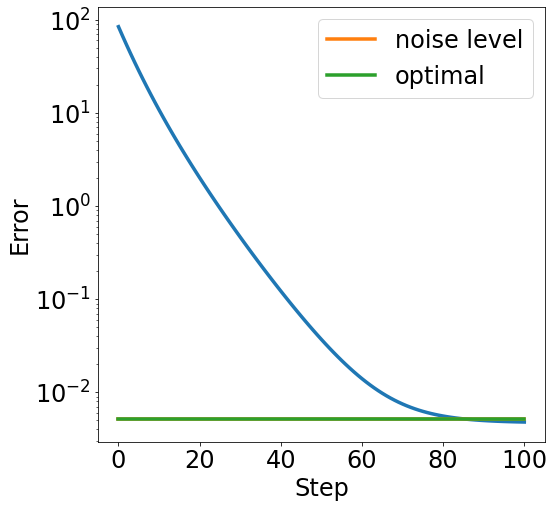

In [35]:
x0 = np.random.normal(0, 1, n)
xs = gradient_descent(x0, [0.1]*100, gradient)
error_plot([objective(x) for x in xs])
plt.plot(range(len(xs)), [1/(2*m)*np.linalg.norm(noise)**2]*len(xs),
        label='noise level', **kwargs)
plt.plot(range(len(xs)), [least_squares(A,b,x_opt)]*len(xs),
        label='optimal', **kwargs)
_ = plt.legend()

##### Convergence in domain

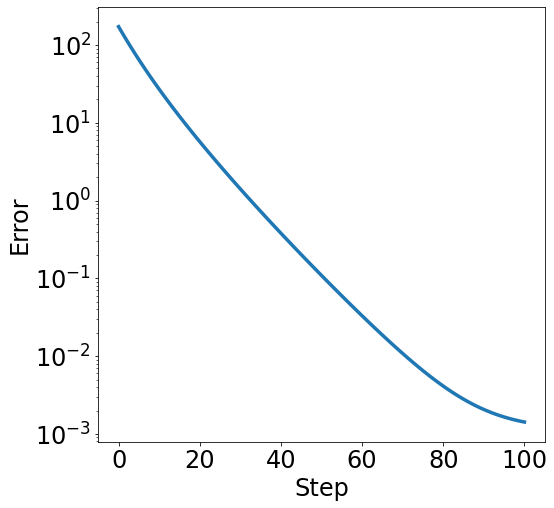

In [36]:
error_plot([np.linalg.norm(x-x_opt)**2 for x in xs])

#### Underdetermined case $m < n$

In the underdetermined case, the least squares objective is inevitably not strongly convex, since $A^\top A$ is a rank deficient matrix and hence $\lambda_{\mathrm{min}}(A^\top A)=0.$

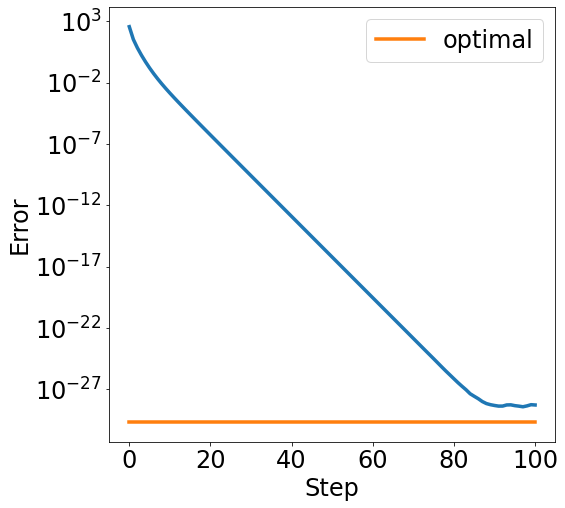

In [37]:
m, n = 100, 1000
A = np.random.normal(0, 1, (m, n))
b = np.random.normal(0, 1, m)
# The least norm solution is given by the pseudo-inverse
x_opt = np.linalg.pinv(A).dot(b)
objective = lambda x: least_squares(A, b, x)
gradient = lambda x: least_squares_gradient(A, b, x)
x0 = np.random.normal(0, 1, n)
xs = gradient_descent(x0, [0.1]*100, gradient)
error_plot([objective(x) for x in xs])
plt.plot(range(len(xs)), [least_squares(A,b,x_opt)]*len(xs),
        label='optimal', **kwargs)
_ = plt.legend()

While we quickly reduce the error, we don't actually converge in domain to the least norm solution. This is just because the function is no longer strongly convex in the underdetermined case.

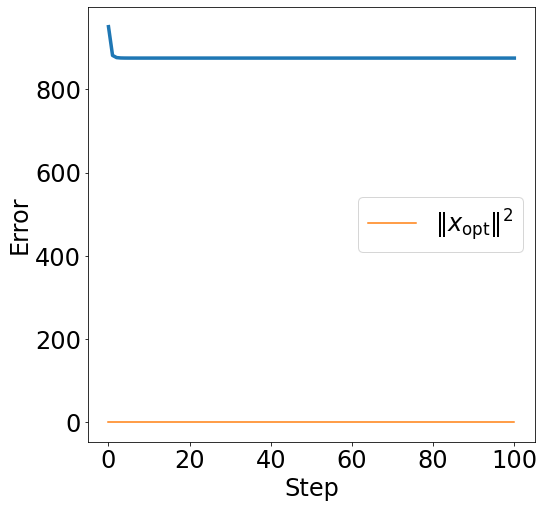

In [38]:
error_plot([np.linalg.norm(x-x_opt)**2 for x in xs], yscale='linear')
plt.plot(range(len(xs)), [np.linalg.norm(x_opt)**2]*len(xs),
         label='$|\!|x_{\mathrm{opt}}|\!|^2$')
plt.legend()

### $\ell_2$-regularized least squares

In the underdetermined case, it is often desirable to restore strong convexity of the objective function by adding an $\ell_2^2$-penality, also known as *Tikhonov regularization*, $\ell_2$-regularization, or *weight decay*.

<p>
$$\frac1{2m}\|Ax-b\|^2 + \frac{\alpha}2\|x\|^2$$
</p>

Note: With this modification the objective is $\alpha$-strongly convex again.


In [39]:
def least_squares_l2(A, b, x, alpha=0.1):
    return least_squares(A, b, x) + (alpha/2) * x.dot(x)

def least_squares_l2_gradient(A, b, x, alpha=0.1):
    return least_squares_gradient(A, b, x) + alpha * x

Let's create a least squares instance.

In [40]:
m, n = 100, 1000
A = np.random.normal(0, 1, (m, n))
b = A.dot(np.random.normal(0, 1, n))
objective = lambda x: least_squares_l2(A, b, x)
gradient = lambda x: least_squares_l2_gradient(A, b, x)

Note that we can find the optimal solution to the optimization problem in closed form without even running gradient descent by computing $x_{\mathrm{opt}}=(A^\top+\alpha I)^{-1}A^\top b.$ Please verify that this point is indeed optimal.

In [42]:
x_opt = np.linalg.inv(A.T.dot(A) + 0.1*np.eye(1000)).dot(A.T).dot(b)

Here's how gradient descent fares.

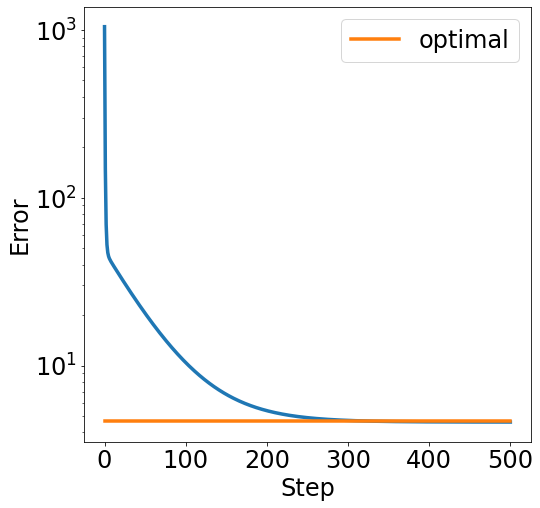

In [43]:
x0 = np.random.normal(0, 1, n)
xs = gradient_descent(x0, [0.1]*500, gradient)
error_plot([objective(x) for x in xs])
plt.plot(range(len(xs)), [least_squares_l2(A,b,x_opt)]*len(xs),
        label='optimal', **kwargs)
_ = plt.legend()

You see that the error doesn't decrease below a certain level due to the regularization term. This is not a bad thing. In fact, the regularization term gives as *strong convexity* which leads to convergence in domain again:

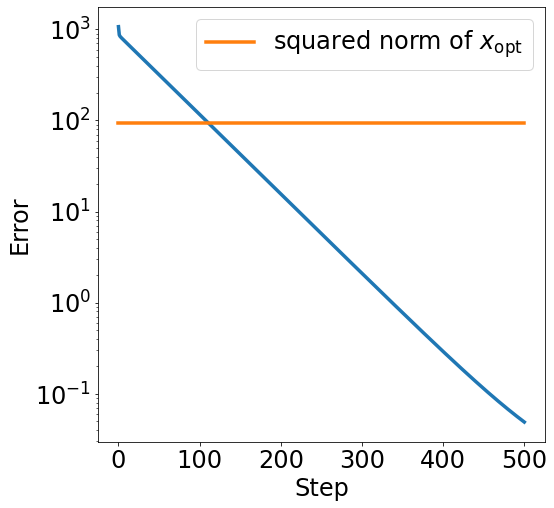

In [44]:
xs = gradient_descent(x0, [0.1]*500, gradient)
error_plot([np.linalg.norm(x-x_opt)**2 for x in xs])
plt.plot(range(len(xs)), [np.linalg.norm(x_opt)**2]*len(xs),
        label='squared norm of $x_{\mathrm{opt}}$', **kwargs)
_ = plt.legend()

### The magic of implicit regularization

Sometimes simply running gradient descent from a suitable initial point has a regularizing effect on its own **without introducing an explicit regularization term**.

We will see this below where we revisit the unregularized least squares objective, but initialize gradient descent from the origin rather than a random gaussian point.

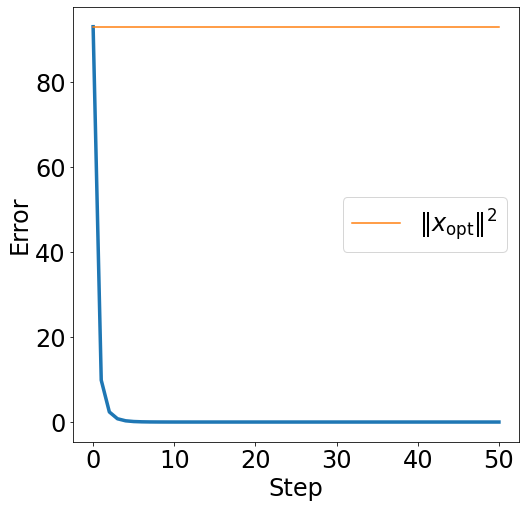

In [45]:
# We initialize from 0
x0 = np.zeros(n)
# Note this is the gradient w.r.t. the unregularized objective!
gradient = lambda x: least_squares_gradient(A, b, x)
xs = gradient_descent(x0, [0.1]*50, gradient)
error_plot([np.linalg.norm(x_opt-x)**2 for x in xs], yscale='linear')
plt.plot(range(len(xs)), [np.linalg.norm(x_opt)**2]*len(xs),
         label='$|\!|x_{\mathrm{opt}}|\!|^2$')
plt.legend()

*Incredible!* We converge to the minimum norm solution!

Implicit regularization is a deep phenomenon that's an active research topic in learning and optimization. It's exciting that we see it play out in this simple least squares problem already!

### LASSO

LASSO is the name for $\ell_1$-regularized least squares regression:

<p>
$$\frac1{2m}\|Ax-b\|^2 + \alpha\|x\|_1$$
</p>

We will see that LASSO is able to fine *sparse* solutions if they exist. This is a common motivation for using an $\ell_1$-regularizer.

In [46]:
def lasso(A, b, x, alpha=0.1):
    return least_squares(A, b, x) + alpha * np.linalg.norm(x, 1)

def ell1_subgradient(x):
    """Subgradient of the ell1-norm at x."""
    g = np.ones(x.shape)
    g[x < 0.] = -1.0
    return g

def lasso_subgradient(A, b, x, alpha=0.1):
    """Subgradient of the lasso objective at x"""
    return least_squares_gradient(A, b, x) + alpha*ell1_subgradient(x)

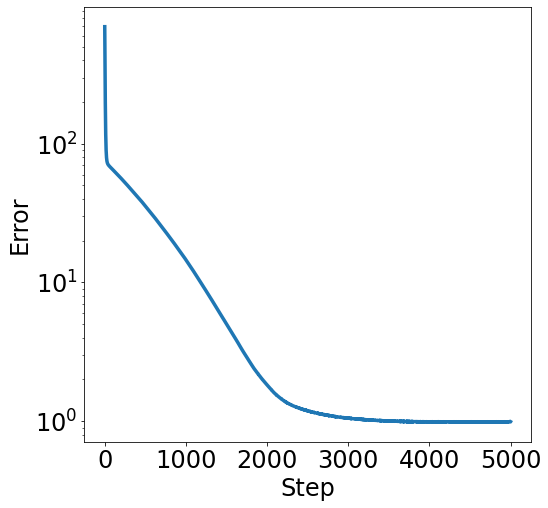

In [51]:
m, n = 100, 1000
A = np.random.normal(0, 1, (m, n))
x_opt = np.zeros(n)
x_opt[:10] = 1.0
b = A.dot(x_opt)
x0 = np.random.normal(0, 1, n)
xs = gradient_descent(x0, [0.01]*5000, lambda x: lasso_subgradient(A, b, x))
error_plot([lasso(A, b, x) for x in xs])

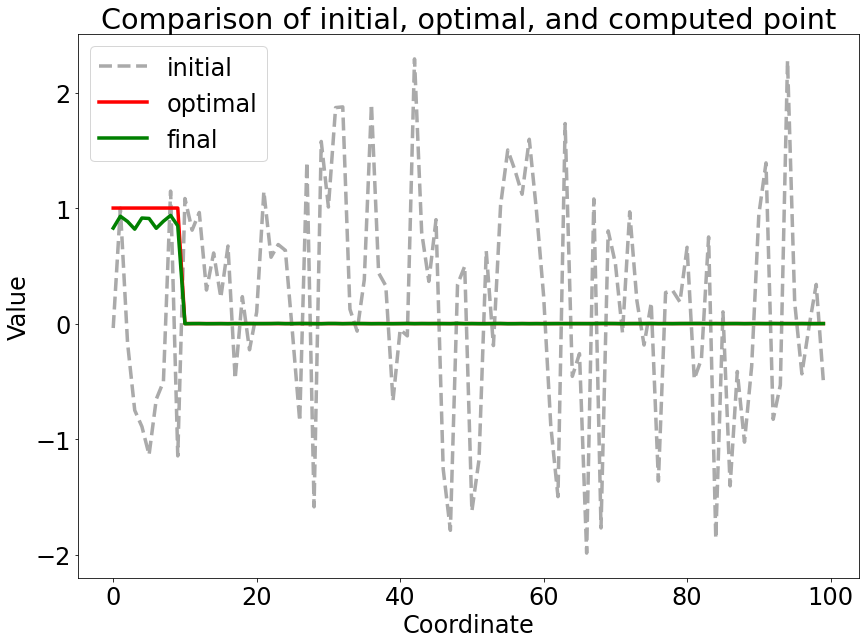

In [52]:
plt.figure(figsize=(14,10))
plt.title('Comparison of initial, optimal, and computed point')
idxs = range(100)
plt.plot(idxs, x0[idxs], '--', color='#aaaaaa', label='initial', **kwargs)
plt.plot(idxs, x_opt[idxs], 'r-', label='optimal', **kwargs)
plt.plot(idxs, xs[-1][idxs], 'g-', label='final', **kwargs)
plt.xlabel('Coordinate')
plt.ylabel('Value')
plt.legend()

As promised, LASSO correctly identifies the significant coordinates of the optimal solution. This is why, in practice, LASSO is a popular tool for feature selection.

Play around with this plot to inspect other points along the way, e.g., the point that achieves lowest objective value. Why does the objective value go up even though we continue to get better solutions?

### Support Vector Machines

In a linear classification problem, we're given $m$ labeled points $(a_i, y_i)$ and we wish to find a hyperplane given by a point $x$ that separates them so that 

* $\langle a_i, x\rangle \ge 1$ when $y_i=1$, and 
* $\langle a_i, x\rangle \le -1$ when $y_i = -1$

The smaller the norm $\|x\|$ the larger the *margin* between positive and negative instances. Therefore, it makes sense to throw in a regularizer that penalizes large norms. This leads to the objective.

<p>
$$\frac 1m \sum_{i=1}^m \max\{1-y_i(a_i^\top x), 0\} + \frac{\alpha}2\|x\|^2$$
</p>

In [54]:
def hinge_loss(z):
    return np.maximum(1.-z, np.zeros(z.shape))

def svm_objective(A, y, x, alpha=0.1):
    """SVM objective."""
    m, _ = A.shape
    return np.mean(hinge_loss(np.diag(y).dot(A.dot(x))))+(alpha/2)*x.dot(x)

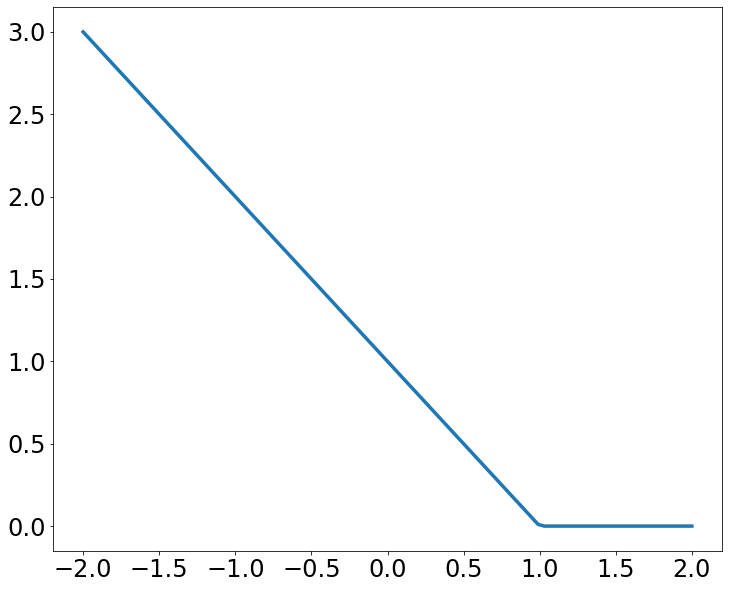

In [55]:
z = np.linspace(-2, 2, 100)
plt.figure(figsize=(12,10))
plt.plot(z, hinge_loss(z), **kwargs)

In [56]:
def hinge_subgradient(z):
    g = np.zeros(z.shape)
    g[z < 1] = -1.
    return g

def svm_subgradient(A, y, x, alpha=0.1):
    g1 = hinge_subgradient(np.diag(y).dot(A.dot(x)))
    g2 = np.diag(y).dot(A)
    return g1.dot(g2) + alpha*x

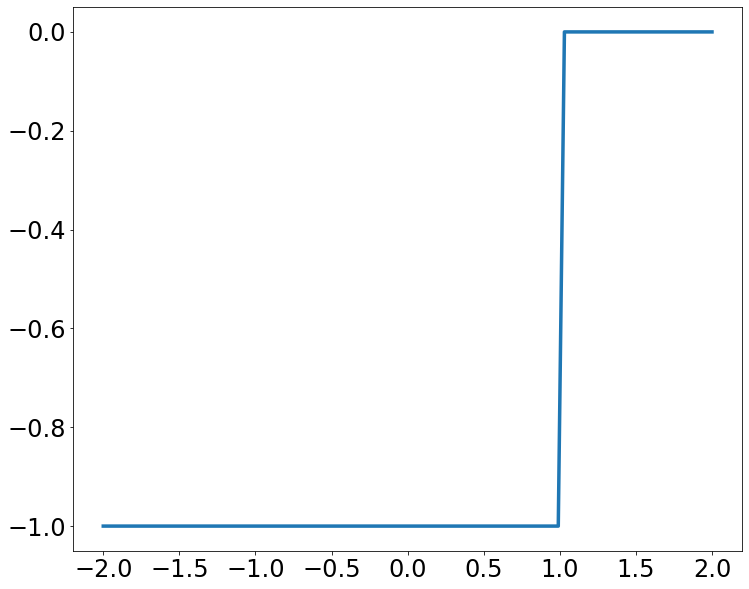

In [57]:
plt.figure(figsize=(12,10))
plt.plot(z, hinge_subgradient(z), **kwargs)

In [58]:
m, n = 1000, 100
A = np.vstack([np.random.normal(0.1, 1, (m//2, n)),
               np.random.normal(-0.1, 1, (m//2, n))])
y = np.hstack([np.ones(m//2), -1.*np.ones(m//2)])
x0 = np.random.normal(0, 1, n)
xs = gradient_descent(x0, [0.01]*100, 
                      lambda x: svm_subgradient(A, y, x, 0.05))

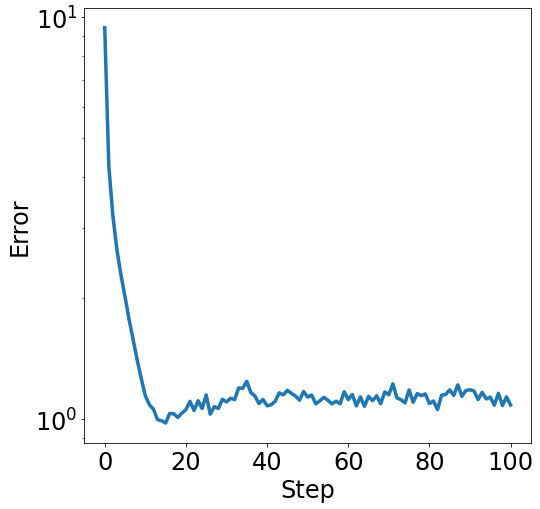

In [59]:
error_plot([svm_objective(A, y, x) for x in xs])

Let's see if averaging out the solutions gives us an improved function value.

In [ ]:
xavg = 0.0
for x in xs:
    xavg += x
svm_objective(A, y, xs[-1]), svm_objective(A, y, xavg/len(xs))

(1.1027879681041983, 0.9452897105048998)

We can also look at the accuracy of our linear model for predicting the labels. From how we defined the data, we can see that the all ones vector is the highest accuracy classifier in the limit of infinite data (very large $m$). For a finite data set, the accuracy could be even higher due to random fluctuations.

In [ ]:
def accuracy(A, y, x):
    return np.mean(np.diag(y).dot(A.dot(x))>0)

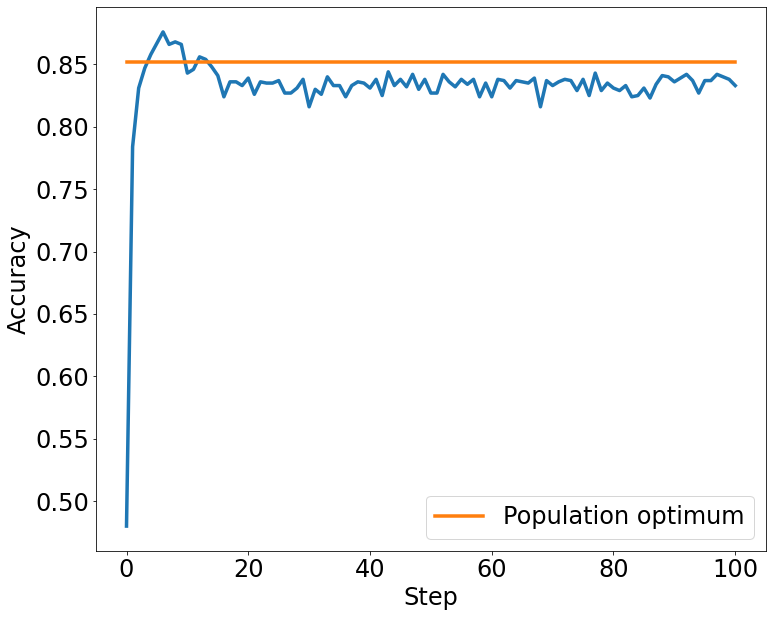

In [ ]:
plt.figure(figsize=(12,10))
plt.ylabel('Accuracy')
plt.xlabel('Step')
plt.plot(range(len(xs)), [accuracy(A, y, x) for x in xs], **kwargs)
plt.plot(range(len(xs)), [accuracy(A, y, np.ones(n))]*len(xs),
        label='Population optimum', **kwargs)
_ = plt.legend()

We see that the accuracy spikes pretty early and drops a bit as we train for too long.

### Sparse Inverse Covariance Estimation

Given a positive semidefinite matrix $S\in\mathbb{R}^{n\times n}$ the objective function in sparse inverse covariance estimation is as follows:

<p>
$$ \min_{X\in\mathbb{R}^{n\times n}, X\succeq 0} 
\langle S, X\rangle - \log\det(X) + \alpha\|X\|_1$$
</p>

Here, we define
$$\langle S, X\rangle = \mathrm{trace}(S^\top X)$$
and
$$\|X\|_1 = \sum_{ij}|X_{ij}|.$$

Typically, we think of the matrix $S$ as a sample covariance matrix of a set of vectors $a_1,\dots, a_m,$ defined as:
$$
S = \frac1{m-1}\sum_{i=1}^n a_ia_i^\top
$$
The example also highlights the utility of automatic differentiation as provided by the `autograd` package that we'll regularly use. In a later lecture we will understand exactly how automatic differentiation works. For now we just treat it as a blackbox that gives us gradients.

In [64]:
import autograd.numpy as np
from autograd import grad

np.random.seed(1337)

In [ ]:
def sparse_inv_cov(S, X, alpha=0.1):
    return (np.trace(S.T.dot(X))
            - np.log(np.linalg.det(X))
            + alpha * np.sum(np.abs(X)))

In [ ]:
n = 5
A = np.random.normal(0, 1, (n, n))
S = A.dot(A.T)
objective = lambda X: sparse_inv_cov(S, X)
# autograd provides a "gradient", yay!
gradient = grad(objective)

We also need to worry about the projection onto the positive semidefinite cone, which corresponds to truncating eigenvalues.

In [ ]:
def projection(X):
    """Projection onto positive semidefinite cone."""
    es, U = np.linalg.eig(X)
    es[es<0] = 0.
    return U.dot(np.diag(es).dot(U.T))

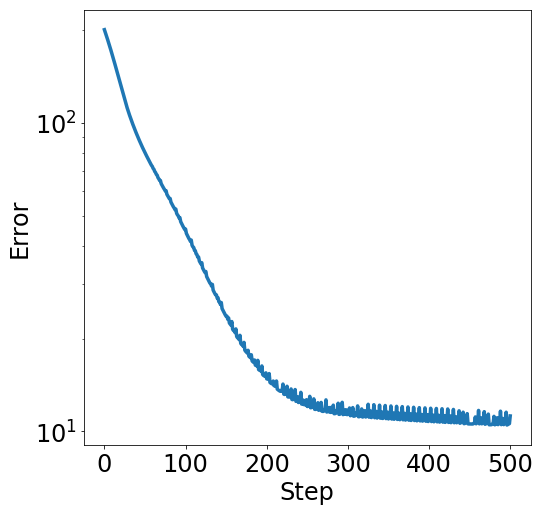

In [ ]:
A0 = np.random.normal(0, 1, (n,n))
X0 = A0.dot(A0.T)
Xs = gradient_descent(X0, [0.01]*500, gradient, projection)
error_plot([objective(X) for X in Xs])

<a id="madness"></a>

# Going crazy with autograd

Just for fun, we'll go through a crazy example below. We can use `autograd` not just for getting gradients for natural objectives, we can in principle also use it to tune hyperparameters of our optimizer, like the step size schedulde.

Below we see how we can find a better 10-step learning rate schedules for optimizing a quadratic. This is mostly just for illustrative purposes (although some researchers are exploring these kinds of ideas more seriously).

In [60]:
x0 = np.random.normal(0, 1, 1000)

In [61]:
def f(x):
    return 0.5*np.dot(x,x)

def optimizer(steps):
    """Optimize a quadratic with the given steps."""
    xs = gradient_descent(x0, steps, grad(f))
    return f(xs[-1])

The function `optimizer` is a non-differentiable function of its input `steps`. Nontheless, `autograd` will provide a gradient that we can stick into gradient descent. That is, we're tuning gradient descent with gradient descent.

In [65]:
grad_optimizer = grad(optimizer)

In [66]:
initial_steps = np.abs(np.random.normal(0, 0.1, 10))
better_steps = gradient_descent(initial_steps, [0.001]*500, grad_optimizer)

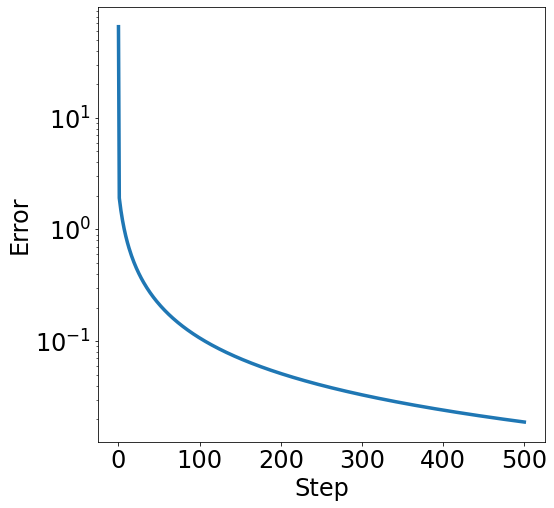

In [67]:
error_plot([optimizer(steps) for steps in better_steps])

As we can see, the learning rate schedules improve dramatically over time. Of course, we already know from the first example that there is a step size schedule that converges in one step. Interestingly, the last schedule we find here doesn't look at all like what we might expect:

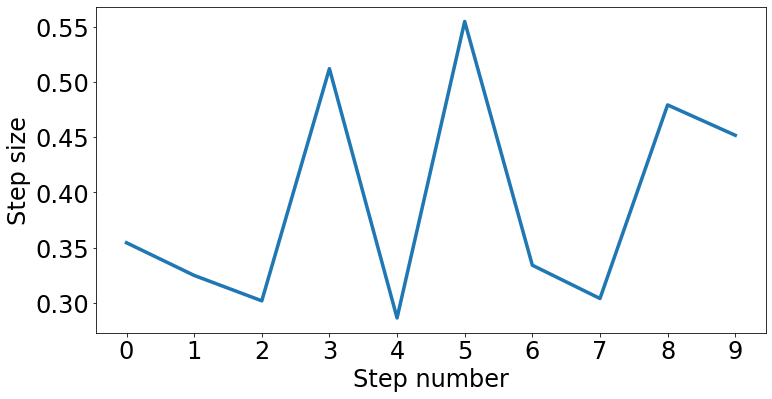

In [68]:
plt.figure(figsize=(12,6))
plt.xticks(range(len(better_steps[-1])))
plt.ylabel('Step size')
plt.xlabel('Step number')
plt.plot(range(len(better_steps[-1])), better_steps[-1], **kwargs)

# Exercises

## Task 1

Find projection on the $S$ set $\pi_S (y) = \pi$ if: 

$$
S = \{x \in \mathbb{R}^n \mid Ax = b, A \in \mathbb{R}^{m \times n}, b \in \mathbb{R}^{m}\}, y \notin S
$$

Hint: Check [fmin.xyz](https://fmin.xyz) 

<font color="lime"> ==YOUR ANSWER== </font>

For following problem:

$$
\left\{ \begin{array}{l} 
\displaystyle \big\lVert Ax - b \big\rVert_2^2 \longrightarrow \min_{x \in \mathbb{R}^n}, \\\\[-1em]
Cx = d.
\end{array} \right. \ \ \begin{array}{l}
A \in \mathbb{R}^{m \times n}, \ m \geq n, \ \text{rg}\, A = n \\
C \in \mathbb{R}^{k \times n}, \ k \leq n, \ \text{rg}\, C = k
\end{array} \ b \in \mathbb{R}^m, \ d \in \mathbb{R}^k
$$

* Write KKT conditions;
* Find $x^\ast$ - solution;

<font color="lime"> ==YOUR ANSWER== </font>

Implement projected gradient descent for following task.

$$
\left\{ \begin{array}{l} 
\displaystyle \big\lVert Ax - b \big\rVert_2^2 \longrightarrow \min_{x \in \mathbb{R}^n}, \\\\[-1em]
Cx = d.
\end{array} \right. \ \ \begin{array}{l}
A \in \mathbb{R}^{m \times n}, \ m \geq n, \ \text{rg}\, A = n \\
C \in \mathbb{R}^{k \times n}, \ k \leq n, \ \text{rg}\, C = k
\end{array} \ b \in \mathbb{R}^m, \ d \in \mathbb{R}^k
$$

Compare with analytical solution and `scipy.optimize`

In [ ]:
import numpy as np

In [ ]:
np.random.seed(1)

A = np.random.randn(100, 20)
b = np.random.randn(100)

C = np.random.randn(10, 20)
d = np.random.randn(10)

In [ ]:
def f(x):
    ### YOUR CODE
    return 

In [ ]:
def proj(C, d, x):
    ### YOUR CODE
    return 

In [ ]:
x = np.zeros(20)
### Projected gradient descent
...

Comparison with `scipy.optimize`

In [ ]:
### YOUR CODE

Comparison with analytical solution

In [ ]:
### YOUR CODE

## Task 2

Besides projected gradient descent, there is other constrainted optimization method - [Augmented Lagrangian method](https://www.him.uni-bonn.de/fileadmin/him/Section6_HIM_v1.pdf). Consider following optimization problem:
$$
\begin{split} & f(x) \to \min\limits_{x \in \mathbb{R}^{n} } \\  & Ax = b \end{split}
$$

Rather explicitly solving the problem, we will solve the following problem:

$$
L(x) = f(x) + \lambda^T (Ax-b) + \frac{\rho}{2} \|Ax - b\|^2
$$

After that we update $\lambda$ and solve new task again, until method doesn't converge

$$
x_{k}=\arg \min _{x \in \Omega} \mathcal{L}\left(x, \lambda_{k-1} ; \rho\right)
$$

$$
\lambda_{k}=\lambda_{k-1}+\rho\left(A x_{k}-b\right)
$$

In [ ]:
import numpy as np
from scipy.optimize import minimize

In [ ]:
np.random.seed(1)
Sigma = np.diag(np.ones(10))
Tmp = np.random.randn(10, 10)
S = Tmp @ Sigma @ Tmp.T
L = np.random.randn(10, 10)
A = L.T @ L
b = np.random.randn(10)

P = np.random.randn(10, 10)
p = np.random.randn(10)
rho = 5

Your task is minimize using Augmented Lagrangian method:
$$
\begin{split} & x^TAx + b^Tx \to \min\limits_{x \in \mathbb{R}^{n} } \\  & Px = p \end{split}
$$

In [ ]:
def f(x):
    ### YOUR CODE
    return 

In [ ]:
def L(x):
    ### YOUR CODE
    return 

Compare this approach with projected gradient descent in any sense you wish (time, function calls, etc - try to be fair)

In [ ]:
### YOUR CODE